## Covid Classification Algorithm
   With 13 predictor variables we need to predict whether a person he/she interacted with chatbot is under panic state of mind or not with the way he/she interacted.

In [47]:
# Importing pandas and numpy libraries
import pandas as pd
import numpy as np

# Importing libraries required for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Importing spark related libraries for session creation
from pyspark.sql import SparkSession

### INSTALLATION OF PIXIEDUST to connect with cloudant database to read the conversation happened with user

In [1]:
## !pip install --upgrade pixiedust

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200726013330-0000
KERNEL_ID = 2d5a71c2-1efc-4000-bfa9-12af0e713f79
    100% |████████████████████████████████| 204kB 4.1MB/s ta 0:00:01
    100% |████████████████████████████████| 1.0MB 4.3MB/s eta 0:00:01
    100% |████████████████████████████████| 5.5MB 2.5MB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 6.0MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 3.7MB/s eta 0:00:01
    100% |████████████████████████████████| 133kB 6.4MB/s eta 0:00:01
    100% |████████████████████████████████| 11.5MB 1.4MB/s eta 0:00:01
    100% |████████████████████████████████| 133kB 6.5MB/s eta 0:00:01
    100% |████████████████████████████████| 143kB 5.6MB/s eta 0:00:01
    100% |████████████████████████████████| 163kB 7.9MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 4.3MB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 4.7MB/s eta 0:00:01
    100%

In [2]:
import pixiedust
pixiedust.installPackage("com.typesafe.play:play-json_2.11:2.5.9")
pixiedust.installPackage("org.apache.bahir:spark-sql-cloudant_2.11:0")

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully
PackageManager is disabled because /home/spark/shared/user-libs/spark2/ is not on the Java Class Path. Please contact your administrator
PackageManager is disabled because /home/spark/shared/user-libs/spark2/ is not on the Java Class Path. Please contact your administrator


### CREATION OF SPARK OBJECT,READ THE CLOUDANT DATA AND CREATION OF DATAFRAME OUT OF IT

In [4]:
# Creating the spark session object
spark = SparkSession.builder.getOrCreate()

In [5]:
# Reading the data from cloudant DB with passing respective credentials
cloudantdata = spark.read.format("org.apache.bahir.cloudant")\
    .option("cloudant.host","af8283bb-2183-43be-bb89-f1d2d2194ef8-bluemix.cloudantnosqldb.appdomain.cloud")\
    .option("cloudant.username", "af8283bb-2183-43be-bb89-f1d2d2194ef8-bluemix")\
    .option("cloudant.password","49aeaafa905e8c6187446ac9c2b813467a7b7c8cf87bb91a928f7a4c5af71fb1")\
    .load("cloudantpartofnoderedbdgpz")


In [6]:
# This code prints the schema and a record count
cloudantdata.printSchema()
cloudantdata.count()

root
 |-- _id: string (nullable = true)
 |-- _rev: string (nullable = true)
 |-- actions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- context: struct (nullable = true)
 |    |-- conversation_id: string (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- location_stats: struct (nullable = true)
 |    |    |-- result: string (nullable = true)
 |    |-- low_confidence: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- out_of_bounds: string (nullable = true)
 |    |-- summary: struct (nullable = true)
 |    |    |-- result: string (nullable = true)
 |    |-- system: struct (nullable = true)
 |    |    |-- _node_output_map: struct (nullable = true)
 |    |    |    |-- handler_10_1585096776761: array (nullable = true)
 |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |-- handler_5_1595417612094: array (nullable = true)
 |    |    |    |    |-- element: string (containsNull = true)
 | 

673

In [7]:
#Selectiong the required data from the cloudant datasource
covid19Data = cloudantdata.select("context.name","context.zipcode","intents.intent")
covid19Data.show()

+----------+-------+--------------------+
|      name|zipcode|              intent|
+----------+-------+--------------------+
|   Hemanth|  21215|[Enter_your_Zipcode]|
|  Michelle|  33023|   [Enter_your_name]|
|   Hemanth|  22314|        [Prevention]|
|   Hemanth|  85013|        [Prevention]|
|   Hemanth|  11203|          [goodbyes]|
|   Krishna| 123456|          [greeting]|
|   Krishna| 123456|          [greeting]|
|   Krishna| 123456|          [greeting]|
|    Pavani|  95134|          [greeting]|
|      John|  21215|   [Enter_your_name]|
|      John|  85013|[Enter_your_Zipcode]|
|Tony Stark|  21215|   [Enter_your_name]|
|   Hemanth|  11203|          [greeting]|
|   Timothy|  21224|   [Enter_your_name]|
|   Timothy|  11203|                  []|
|     James|  11203|   [Enter_your_name]|
|     James|  21215|          [greeting]|
|   Matthew|  21215|   [HandwashingTips]|
|   Anthony|  21215|   [Enter_your_name]|
|   Anthony|  95134|   [HandwashingTips]|
+----------+-------+--------------

In [8]:
# Converting the read coviddata from cloudant db to pandas data frame
import pandas as pd
covidDF = covid19Data.toPandas()
print(covidDF)

                     name zipcode                      intent
0                 Hemanth   21215        [Enter_your_Zipcode]
1                Michelle   33023           [Enter_your_name]
2                 Hemanth   22314                [Prevention]
3                 Hemanth   85013                [Prevention]
4                 Hemanth   11203                  [goodbyes]
5                 Krishna  123456                  [greeting]
6                 Krishna  123456                  [greeting]
7                 Krishna  123456                  [greeting]
8                  Pavani   95134                  [greeting]
9                    John   21215           [Enter_your_name]
10                   John   85013        [Enter_your_Zipcode]
11             Tony Stark   21215           [Enter_your_name]
12                Hemanth   11203                  [greeting]
13                Timothy   21224           [Enter_your_name]
14                Timothy   11203                          []
15      

### PROCESSING AND HANDLING DATA for MODEL BUILDING

In [9]:
# Check on how data looks for further processing
covidDF.tail()

,name,zipcode,intent
668,Krishna,123456,[Enter_your_Zipcode]
669,Krishna,123456,[greeting]
670,Hemanth,95134,[Enter_your_name]
671,Emma Watson,10021,[GenericQuestions]
672,Emma Watson,10021,[greeting]


In [10]:
# Check on zipcodes and names 
print(covidDF.name.value_counts())
print(covidDF.zipcode.value_counts())

11203     64
21215     63
22314     63
11223     62
85013     55
10021     48
10032     47
123456    41
10004     41
95134     39
22003     30
11354     28
30024     26
760005    17
21224     14
33023     13
500089    11
10005     10
Name: zipcode, dtype: int64

In [11]:
# Creating copy for further processing 
covidDataProcess = covidDF.copy()

In [12]:
covidDataProcess.head(10)

,name,zipcode,intent
0,Hemanth,21215,[Enter_your_Zipcode]
1,Michelle,33023,[Enter_your_name]
2,Hemanth,22314,[Prevention]
3,Hemanth,85013,[Prevention]
4,Hemanth,11203,[goodbyes]
5,Krishna,123456,[greeting]
6,Krishna,123456,[greeting]
7,Krishna,123456,[greeting]
8,Pavani,95134,[greeting]
9,John,21215,[Enter_your_name]


In [13]:
# Remove of duplicates from the data
covidDataProcess = covidDataProcess.loc[covidDataProcess.astype(str).drop_duplicates().index]

### REMOVAL OF SPECIAL CHARACTERS and handling columns for processing

In [14]:
# Removal of special characters from the column data
covidDataProcess['intent'] = covidDataProcess['intent'].astype(str).str.strip('[]')

In [15]:
covidDataProcess['questions'] = covidDataProcess['intent'].astype(str)

In [16]:
covidDataProcess['questions'] = covidDataProcess['questions'].str.replace('\'', '')

In [17]:
covidDataProcess.questions.value_counts()

Enter_your_name             61
greeting                    57
Enter_your_Zipcode          53
goodbyes                    34
GenericQuestions            31
HandwashingTips             31
How_many_cases              31
Testing                     31
Prevention                  26
Symptoms                    25
ColdRelatedQuestions        25
CoughRelatedQuestions       24
BodyPainRelatedQuestions    22
Symptomsinchildren          21
                            15
AttendingFuneral             1
AnimalContact                1
spreadviafood                1
Name: questions, dtype: int64

### Deleting of columns which doesnt add any benefit for model building ,as the below columns like 
      1) greeting,enter_your_name,enter_your_zipcode,goodbyes doesnt add any benefit as predictor variables

In [18]:
# Excluding the columns which are of no use
covidDataAfterProcess = covidDataProcess[(covidDataProcess.questions!='greeting') & (covidDataProcess.questions!='Enter_your_name') & (covidDataProcess.questions!='Enter_your_Zipcode') & (covidDataProcess.questions!='goodbyes')]

In [19]:
# currently we have a dimension of 285 columns
covidDataAfterProcess.shape

(285, 4)

In [20]:
# Droping the intent column as we made a copy for the same
covidDataAfterProcess = covidDataAfterProcess.drop(['intent'],axis=1)

In [21]:
# Excluding the null column data
covidDataAfterProcess = covidDataAfterProcess[covidDataAfterProcess['questions']!='']

In [22]:
# creation of new column covidanswer to append the same to the question asked by user in chatbot
covidDataAfterProcess['covidanswer']='1';

### Creation of PIVOT table and converting the LONG rows to WIDE columns

In [24]:
pivoted=covidDataAfterProcess.pivot_table(index='name', columns='questions', values=['covidanswer'], aggfunc='first')

In [25]:
flattened = pd.DataFrame(pivoted.to_records())

In [26]:
flattened.columns = [hdr.replace("('covidanswer',", "").replace(")", "").replace('\'', '') \
                     for hdr in flattened.columns]
flattened

,name,AnimalContact,AttendingFuneral,BodyPainRelatedQuestions,ColdRelatedQuestions,CoughRelatedQuestions,GenericQuestions,HandwashingTips,How_many_cases,Prevention,Symptoms,Symptomsinchildren,Testing,spreadviafood
0,Adolf Hitler,NaN,NaN,NaN,1,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN
1,Amanda,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
2,Anthony,NaN,NaN,1,1,1,1,1,1,1,NaN,1,1,NaN
3,Anushka Sharma,NaN,NaN,1,NaN,NaN,1,NaN,1,NaN,NaN,1,1,NaN
4,Arvind Krishna,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,1,NaN
5,Atal Bihari Vajpayee,NaN,NaN,1,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
6,Bhagat Singh,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,1,NaN,NaN
7,Brian,NaN,NaN,NaN,1,NaN,1,1,NaN,1,NaN,NaN,1,NaN
8,Charles,NaN,NaN,NaN,1,NaN,1,1,1,1,NaN,NaN,1,NaN
9,Christopher,NaN,NaN,1,1,NaN,1,NaN,1,NaN,1,NaN,NaN,NaN


In [27]:
# replacing nan values to 0
import numpy as np
covidFinaldata = flattened.replace(np.nan, 0)

In [28]:
covidFinaldata.shape

(38, 14)

In [29]:
covidFinaldata.columns.tolist()

['name',
 ' AnimalContact',
 ' AttendingFuneral',
 ' BodyPainRelatedQuestions',
 ' ColdRelatedQuestions',
 ' CoughRelatedQuestions',
 ' GenericQuestions',
 ' HandwashingTips',
 ' How_many_cases',
 ' Prevention',
 ' Symptoms',
 ' Symptomsinchildren',
 ' Testing',
 ' spreadviafood']

In [30]:
covidFinaldata.columns = covidFinaldata.columns.str.strip()

In [31]:
covidFinaldata = covidFinaldata[['name','Symptoms','AttendingFuneral','Testing','spreadviafood','AnimalContact','How_many_cases','CoughRelatedQuestions','ColdRelatedQuestions','BodyPainRelatedQuestions','Prevention','HandwashingTips','Symptomsinchildren']]

### Derived Variables creation from the existing predictor variables
  1)CovidNewsquestions  --- User who interacted with bot and researched questions related to testing and funerls will fall under this variable
  2) CovidStatQuestions  --- User who interacted with bot and researched questions related to animal contact and spreading will fall under this variable

In [32]:
covidFinaldata.AttendingFuneral = pd.to_numeric(covidFinaldata.AttendingFuneral, errors='coerce').astype(np.int64)
covidFinaldata.Testing = pd.to_numeric(covidFinaldata.Testing, errors='coerce').astype(np.int64)

In [33]:
covidFinaldata.spreadviafood = pd.to_numeric(covidFinaldata.spreadviafood, errors='coerce').astype(np.int64)
covidFinaldata.AnimalContact = pd.to_numeric(covidFinaldata.AnimalContact, errors='coerce').astype(np.int64)

In [34]:
covidFinaldata['CovidNewsquestions'] = covidFinaldata.AttendingFuneral + covidFinaldata.Testing

In [35]:
covidFinaldata['CovidStatQuestions'] = covidFinaldata.spreadviafood + covidFinaldata.AnimalContact

In [36]:
covidFinaldata.loc[covidFinaldata['CovidNewsquestions'] > 1, 'CovidNewsquestions'] = 1
covidFinaldata.loc[covidFinaldata['CovidStatQuestions'] > 1, 'CovidStatQuestions'] = 1

In [37]:
covidFinaldata

,name,Symptoms,AttendingFuneral,Testing,spreadviafood,AnimalContact,How_many_cases,CoughRelatedQuestions,ColdRelatedQuestions,BodyPainRelatedQuestions,Prevention,HandwashingTips,Symptomsinchildren,CovidNewsquestions,CovidStatQuestions
0,Adolf Hitler,0,0,0,0,0,1,0,1,0,1,1,0,0,0
1,Amanda,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,Anthony,0,0,1,0,0,1,1,1,1,1,1,1,1,0
3,Anushka Sharma,0,0,1,0,0,1,0,0,1,0,0,1,1,0
4,Arvind Krishna,1,0,1,0,0,0,0,0,0,0,0,0,1,0
5,Atal Bihari Vajpayee,0,0,0,0,0,0,1,0,1,0,1,0,0,0
6,Bhagat Singh,0,0,0,0,0,1,0,0,0,0,1,1,0,0
7,Brian,0,0,1,0,0,0,0,1,0,1,1,0,1,0
8,Charles,0,0,1,0,0,1,0,1,0,1,1,0,1,0
9,Christopher,1,0,0,0,0,1,0,1,1,0,0,0,0,0


In [38]:
## Merge of datasets to get the geographical related data and personal data
covidDataZipcode = covidDataAfterProcess[['name','zipcode']]
covidDataZipcode = covidDataZipcode.groupby('name')
covidDataZipcode = covidDataZipcode.first()
master_frame = pd.merge(covidFinaldata, covidDataZipcode, how='inner', on='name')
master_frame

,name,Symptoms,AttendingFuneral,Testing,spreadviafood,AnimalContact,How_many_cases,CoughRelatedQuestions,ColdRelatedQuestions,BodyPainRelatedQuestions,Prevention,HandwashingTips,Symptomsinchildren,CovidNewsquestions,CovidStatQuestions,zipcode
0,Adolf Hitler,0,0,0,0,0,1,0,1,0,1,1,0,0,0,11223
1,Amanda,0,0,0,0,0,0,1,0,0,1,0,0,0,0,30024
2,Anthony,0,0,1,0,0,1,1,1,1,1,1,1,1,0,95134
3,Anushka Sharma,0,0,1,0,0,1,0,0,1,0,0,1,1,0,10004
4,Arvind Krishna,1,0,1,0,0,0,0,0,0,0,0,0,1,0,10005
5,Atal Bihari Vajpayee,0,0,0,0,0,0,1,0,1,0,1,0,0,0,11354
6,Bhagat Singh,0,0,0,0,0,1,0,0,0,0,1,1,0,0,11354
7,Brian,0,0,1,0,0,0,0,1,0,1,1,0,1,0,22314
8,Charles,0,0,1,0,0,1,0,1,0,1,1,0,1,0,22314
9,Christopher,1,0,0,0,0,1,0,1,1,0,0,0,0,0,10021


In [39]:
# Creation of copy for further process
mstFrm = master_frame.copy()

In [40]:
mstFrm.head(10)

,name,Symptoms,AttendingFuneral,Testing,spreadviafood,AnimalContact,How_many_cases,CoughRelatedQuestions,ColdRelatedQuestions,BodyPainRelatedQuestions,Prevention,HandwashingTips,Symptomsinchildren,CovidNewsquestions,CovidStatQuestions,zipcode
0,Adolf Hitler,0,0,0,0,0,1,0,1,0,1,1,0,0,0,11223
1,Amanda,0,0,0,0,0,0,1,0,0,1,0,0,0,0,30024
2,Anthony,0,0,1,0,0,1,1,1,1,1,1,1,1,0,95134
3,Anushka Sharma,0,0,1,0,0,1,0,0,1,0,0,1,1,0,10004
4,Arvind Krishna,1,0,1,0,0,0,0,0,0,0,0,0,1,0,10005
5,Atal Bihari Vajpayee,0,0,0,0,0,0,1,0,1,0,1,0,0,0,11354
6,Bhagat Singh,0,0,0,0,0,1,0,0,0,0,1,1,0,0,11354
7,Brian,0,0,1,0,0,0,0,1,0,1,1,0,1,0,22314
8,Charles,0,0,1,0,0,1,0,1,0,1,1,0,1,0,22314
9,Christopher,1,0,0,0,0,1,0,1,1,0,0,0,0,0,10021


In [41]:
# Find column wise percentage of nulls

mstFrm.isnull().sum()/len(mstFrm.index)

name                        0.0
Symptoms                    0.0
AttendingFuneral            0.0
Testing                     0.0
spreadviafood               0.0
AnimalContact               0.0
How_many_cases              0.0
CoughRelatedQuestions       0.0
ColdRelatedQuestions        0.0
BodyPainRelatedQuestions    0.0
Prevention                  0.0
HandwashingTips             0.0
Symptomsinchildren          0.0
CovidNewsquestions          0.0
CovidStatQuestions          0.0
zipcode                     0.0
dtype: float64

## TRAINING THE MODEL WITH HISTORICAL DATA 

## Reading the historical data file and training the model in a better way to predict the realtime dataflow from cloudant DB

In [42]:
# The code was removed by Watson Studio for sharing.

,PersonName,Zipcode,symptomatic questions,CovidNewsquestions,CovidStatQuestions,NearbyCasesSearch,CoughRelatedQuestions,COldrelatedQuestions,BodyPainsRelatedQuestions,CovidpreventionRelatedQuestions,HandWashTechniqueQuestions,ChildSymptomicQuestions,Zone
0,as,1,1,0,1,1,1,1,1,0,1,1,panic
1,das,41,1,0,1,1,1,0,1,1,0,1,panic
2,dsd,54351,1,0,1,0,1,0,0,0,1,0,ok
3,dsddsa,5435541,1,0,0,1,1,1,1,0,0,1,panic
4,tfefsd,678781,0,1,1,1,1,1,1,1,1,0,panic


In [43]:
# Tag the Panic as 1 and Ok as 0

covid19['Zone'] = np.where((covid19['Zone'] == 'panic'), '1', '0')

In [44]:
# Cast the resulting column into int datatype

covid19.Zone = covid19.Zone.apply(np.int64)

### Checking the data percentage on target column for class imbalance

In [45]:
# Find the percentage of churners
((covid19['Zone'].value_counts())/len(covid19.index))*100

0    54.166667
1    45.833333
Name: Zone, dtype: float64

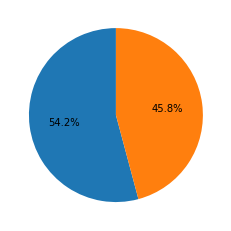

In [48]:
# Plot showing the Panic distribution

plt.pie((((covid19['Zone'].value_counts())/len(covid19.index))*100).reset_index()['Zone'], autopct='%1.1f%%', startangle=90, radius = 1)
plt.show()

Since the percentage of the two categories is balanced, there is no class imbalance and wont cause the algorithms to 
wrongly tag the panic as non panic(ok) .

In [49]:
# Work on the copy of the dataset

ch = covid19.copy()

In [50]:
ch.shape

(24, 13)

In [51]:
# Find the percentage of churners
((ch['Zone'].value_counts())/len(ch.index))*100

0    54.166667
1    45.833333
Name: Zone, dtype: float64

In [52]:
# Putting feature variable to X
X = ch.drop(['Zone','Zipcode','PersonName'],axis=1)

# Putting response variable to y
y = ch['Zone']

In [53]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [54]:
# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [55]:
# Find index of feature columns with correlation greater than 0.69
to_drop = [column for column in upper.columns if any(upper[column] > 0.60)]

In [56]:
to_drop

['CoughRelatedQuestions',
 'BodyPainsRelatedQuestions',
 'ChildSymptomicQuestions']

In [57]:
X_train_2 = X_train.drop(to_drop, 1)
X_test_2 = X_test.drop(to_drop, 1)

In [58]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression()
logsk.fit(X_train_2, y_train)

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [59]:
# Predicted probabilities
y_pred = logsk.predict_proba(X_test_2)

In [60]:
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

In [61]:
y_pred_df

,0,1
0,0.258286,0.741714
1,0.461285,0.538715
2,0.680949,0.319051
3,0.440551,0.559449
4,0.537315,0.462685
5,0.270123,0.729877
6,0.150672,0.849328
7,0.618038,0.381962


In [62]:
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

In [63]:
# Let's see the head
y_pred_1.head()

,1
0,0.741714
1,0.538715
2,0.319051
3,0.559449
4,0.462685


In [64]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [66]:
# Putting CustID to index
y_test_df['PersonName'] = y_test_df.index

In [67]:
y_test_df

,Zone,PersonName
6,1,6
9,0,9
18,0,18
21,1,21
13,0,13
5,0,5
12,1,12
22,0,22


In [68]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [69]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)

In [70]:
y_pred_final.head()

,Zone,PersonName,1
0,1,6,0.741714
1,0,9,0.538715
2,0,18,0.319051
3,1,21,0.559449
4,0,13,0.462685


In [71]:
df_out=X.copy()

In [72]:
# Predicted probabilities
y_wholePred = logsk.predict_proba(df_out.drop(to_drop, 1))

In [73]:
y_pred_df = pd.DataFrame(y_wholePred)
y_pred_2 = y_pred_df.iloc[:,[1]]
y_pred_2

,1
0,0.660249
1,0.743448
2,0.410708
3,0.827652
4,0.549175
5,0.729877
6,0.741714
7,0.461659
8,0.317083
9,0.538715


In [74]:
# Removing index for both dataframes to append them side by side 
y_pred_2.reset_index(drop=True, inplace=True)
ch.reset_index(drop=True, inplace=True)

In [75]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([ch,y_pred_2],axis=1)

In [77]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Covid19_Prob'})
y_pred_final['predicted'] = y_pred_final.Covid19_Prob.map( lambda x: 1 if x > 0.5 else 0)

In [78]:
y_pred_final.head()

,PersonName,Zipcode,symptomatic questions,CovidNewsquestions,CovidStatQuestions,NearbyCasesSearch,CoughRelatedQuestions,COldrelatedQuestions,BodyPainsRelatedQuestions,CovidpreventionRelatedQuestions,HandWashTechniqueQuestions,ChildSymptomicQuestions,Zone,Covid19_Prob,predicted
0,as,1,1,0,1,1,1,1,1,0,1,1,1,0.660249,1
1,das,41,1,0,1,1,1,0,1,1,0,1,1,0.743448,1
2,dsd,54351,1,0,1,0,1,0,0,0,1,0,0,0.410708,0
3,dsddsa,5435541,1,0,0,1,1,1,1,0,0,1,1,0.827652,1
4,tfefsd,678781,0,1,1,1,1,1,1,1,1,0,1,0.549175,1


In [79]:
from sklearn import metrics
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.Zone, y_pred_final.predicted )
confusion

array([[11,  2],
       [ 0, 11]])

In [80]:
#Let's check the overall accuracy.
metrics.accuracy_score( y_pred_final.Zone, y_pred_final.predicted)

0.9166666666666666

### PROCESSING THE REALTIME DATA TO THE TRAINED MODEL TO PREDICT THE PATTERN

In [115]:
covid19RealtimeData = mstFrm.copy()

In [116]:
covid19RealtimeData = covid19RealtimeData.drop(['AttendingFuneral', 'Testing','spreadviafood','AnimalContact'], axis=1)

In [117]:
y_pred_final.columns

Index(['PersonName', 'Zipcode', 'symptomatic questions', 'CovidNewsquestions',
       'CovidStatQuestions', 'NearbyCasesSearch', 'CoughRelatedQuestions',
       'COldrelatedQuestions', 'BodyPainsRelatedQuestions',
       'CovidpreventionRelatedQuestions', 'HandWashTechniqueQuestions',
       'ChildSymptomicQuestions', 'Zone', 'Covid19_Prob', 'predicted'],
      dtype='object')

In [118]:
covid19RealtimeData.columns

Index(['name', 'Symptoms', 'How_many_cases', 'CoughRelatedQuestions',
       'ColdRelatedQuestions', 'BodyPainRelatedQuestions', 'Prevention',
       'HandwashingTips', 'Symptomsinchildren', 'CovidNewsquestions',
       'CovidStatQuestions', 'zipcode'],
      dtype='object')

In [119]:
col_dict = {'Symptoms': 'symptomatic questions', 'How_many_cases': 'NearbyCasesSearch',
               'CoughRelatedQuestions': 'CoughRelatedQuestions', 'ColdRelatedQuestions': 'COldrelatedQuestions',
               'BodyPainRelatedQuestions': 'BodyPainsRelatedQuestions', 'HandwashingTips': 'HandWashTechniqueQuestions',
               'Symptomsinchildren': 'ChildSymptomicQuestions', 'How_many_cases': 'NearbyCasesSearch',
               'name': 'PersonName', 'zipcode': 'Zipcode', 'Prevention' : 'CovidpreventionRelatedQuestions' }   ## key→old name, value→new name

covid19RealtimeData.columns = [col_dict.get(x, x) for x in covid19RealtimeData.columns]

In [120]:
covid19RealtimeData.shape

(38, 12)

In [121]:
# Realtime Predicting probabilities
covid19RealtimeData = covid19RealtimeData.drop(['PersonName', 'Zipcode'],axis=1)
y_wholePred_realtime = logsk.predict_proba(covid19RealtimeData.drop(to_drop, 1))

In [122]:
y_pred_realtime_df = pd.DataFrame(y_wholePred_realtime)
y_pred_realtime_2 = y_pred_realtime_df.iloc[:,[1]]
y_pred_realtime_2.head()

,1
0,0.477854
1,0.519656
2,0.605293
3,0.519132
4,0.742660
5,0.437079
6,0.476825
7,0.566432
8,0.605293
9,0.507362


In [123]:
y_pred_realtime_2.reset_index(drop=True, inplace=True)
mstFrm.reset_index(drop=True, inplace=True)

In [124]:
y_pred_realtime_final = pd.concat([mstFrm,y_pred_realtime_2],axis=1)

In [125]:
y_pred_realtime_final= y_pred_realtime_final.rename(columns={ 1 : 'Covid19_Prob'})
y_pred_realtime_final['predicted'] = y_pred_realtime_final.Covid19_Prob.map( lambda x: 1 if x > 0.5 else 0)

In [126]:
y_pred_realtime_final.head()

,name,Symptoms,AttendingFuneral,Testing,spreadviafood,AnimalContact,How_many_cases,CoughRelatedQuestions,ColdRelatedQuestions,BodyPainRelatedQuestions,Prevention,HandwashingTips,Symptomsinchildren,CovidNewsquestions,CovidStatQuestions,zipcode,Covid19_Prob,predicted
0,Adolf Hitler,0,0,0,0,0,1,0,1,0,1,1,0,0,0,11223,0.477854,0
1,Amanda,0,0,0,0,0,0,1,0,0,1,0,0,0,0,30024,0.519656,1
2,Anthony,0,0,1,0,0,1,1,1,1,1,1,1,1,0,95134,0.605293,1
3,Anushka Sharma,0,0,1,0,0,1,0,0,1,0,0,1,1,0,10004,0.519132,1
4,Arvind Krishna,1,0,1,0,0,0,0,0,0,0,0,0,1,0,10005,0.742660,1


## STORING THE PREDICTED VARIABLES TO CSV FORMAT FOR FURTHER INSIGHTS

In [127]:
y_pred_realtime_final.to_csv('covidPatternClassification.csv',index=False)

In [128]:
data = pd.read_csv("covidPatternClassification.csv")
data.head()

,name,Symptoms,AttendingFuneral,Testing,spreadviafood,AnimalContact,How_many_cases,CoughRelatedQuestions,ColdRelatedQuestions,BodyPainRelatedQuestions,Prevention,HandwashingTips,Symptomsinchildren,CovidNewsquestions,CovidStatQuestions,zipcode,Covid19_Prob,predicted
0,Adolf Hitler,0,0,0,0,0,1,0,1,0,1,1,0,0,0,11223,0.477854,0
1,Amanda,0,0,0,0,0,0,1,0,0,1,0,0,0,0,30024,0.519656,1
2,Anthony,0,0,1,0,0,1,1,1,1,1,1,1,1,0,95134,0.605293,1
3,Anushka Sharma,0,0,1,0,0,1,0,0,1,0,0,1,1,0,10004,0.519132,1
4,Arvind Krishna,1,0,1,0,0,0,0,0,0,0,0,0,1,0,10005,0.742660,1


##INSTALLING THE REQUIRED PACKAGES TO STORE THE CSV INTO COS STORAGE IN IBM

In [129]:
!pip install ibm-cos-sdk

    100% |████████████████████████████████| 61kB 3.6MB/s eta 0:00:01
    100% |████████████████████████████████| 829kB 531kB/s eta 0:00:01
    100% |████████████████████████████████| 225kB 6.5MB/s eta 0:00:01
    100% |████████████████████████████████| 552kB 5.9MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/45/1e/0c169c6a5381e241ba7404532c16a21d86ab872c9bed8bdcd4c423954103/requests-2.24.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9f/f0/a391d1463ebb1b233795cabfc0ef38d3db4442339de68f847026199e69d7/urllib3-1.25.10-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5e/c4/6c4fe722df5343c33226

In [131]:
import ibm_boto3
from ibm_botocore.client import Config, ClientError



# Constants for IBM COS values
COS_ENDPOINT = "https://s3-api.us-geo.objectstorage.service.networklayer.com" # Current list avaiable at https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints
COS_API_KEY_ID = "tBJP6LVzcQy4NvUvOCl6gYk-g4vnTIMi673AzS3gydcv" # eg "W00YixxxxxxxxxxMB-odB-2ySfTrFBIQQWanc--P3byk"
COS_INSTANCE_CRN = "crn:v1:bluemix:public:cloud-object-storage:global:a/adf5d6c95fbb4f639efd0a43c86c3d1c:221a8342-941e-48c1-ac66-c55dfef0d045::" # eg "crn:v1:bluemix:public:cloud-object-storage:global:a/3bf0d9003xxxxxxxxxx1c3e97696b71c:d6f04d83-6c4f-4a62-a165-696756d63903::"
COS_AUTH_ENDPOINT = "https://iam.cloud.ibm.com/oidc/token"

# Create resource
cos = ibm_boto3.resource("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_INSTANCE_CRN,
    ibm_auth_endpoint=COS_AUTH_ENDPOINT,
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

In [132]:
def multi_part_upload(bucket_name, item_name, file_path):
    try:
        print("Starting file transfer for {0} to bucket: {1}\n".format(item_name, bucket_name))
        # set 5 MB chunks
        part_size = 1024 * 1024 * 5

        # set threadhold to 15 MB
        file_threshold = 1024 * 1024 * 15

        # set the transfer threshold and chunk size
        transfer_config = ibm_boto3.s3.transfer.TransferConfig(
            multipart_threshold=file_threshold,
            multipart_chunksize=part_size
        )

        # the upload_fileobj method will automatically execute a multi-part upload
        # in 5 MB chunks for all files over 15 MB
        with open(file_path, "rb") as file_data:
            cos.Object(bucket_name, item_name).upload_fileobj(
                Fileobj=file_data,
                Config=transfer_config
            )

        print("Transfer for {0} Complete!\n".format(item_name))
    except ClientError as be:
        print("CLIENT ERROR: {0}\n".format(be))
    except Exception as e:
        print("Unable to complete multi-part upload: {0}".format(e))


In [133]:
multi_part_upload('covidclassification-donotdelete-pr-8ak6n0mijfy2rc','covidPatternClassification.csv','covidPatternClassification.csv')

Starting file transfer for covidPatternClassification.csv to bucket: covidclassification-donotdelete-pr-8ak6n0mijfy2rc

Transfer for covidPatternClassification.csv Complete!



In [167]:
# create client to access our WML service
from watson_machine_learning_client import WatsonMachineLearningAPIClient

wml_credentials = {
  "apikey": "Xz5J-Eufiu7-29sv9jm6LOvaIKMjsE5r55TjUxe8lML_",
  "iam_apikey_description": "Auto-generated for key 7bca1e8d-7bb5-4971-8681-cd512388b68a",
  "iam_apikey_name": "wdp-writer",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/adf5d6c95fbb4f639efd0a43c86c3d1c::serviceid:ServiceId-68f98d04-1120-4972-beec-feb505f1967e",
  "instance_id": "1cab57fd-a73e-4804-b8ea-e6f8c15acfc9",
  "url": "https://us-south.ml.cloud.ibm.com"
}

client = WatsonMachineLearningAPIClient(wml_credentials)
print(client.version)

1.0.95


In [168]:
# Use this cell to do any cleanup of previously created models and deployments
client.repository.list_models()
client.deployments.list()

----  ----  -------  ----
GUID  NAME  CREATED  TYPE
----  ----  -------  ----
----  ----  -----  -------  -------------
GUID  NAME  STATE  CREATED  ARTIFACT_TYPE
----  ----  -----  -------  -------------


In [171]:
meta_props = {
    client.repository.ModelMetaNames.NAME: "Covid Classification",
    client.repository.ModelMetaNames.TYPE: ""
}
published_model = client.repository.store_model(model=logsk, meta_props=meta_props)

Traceback (most recent call last):
  File "/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/watson_machine_learning_client/libs/repo/mlrepositoryclient/model_collection.py", line 463, in _save_spark_pipeline_model
    model_artifact = self._create_pipeline_model(artifact, query_param)
  File "/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/watson_machine_learning_client/libs/repo/mlrepositoryclient/model_collection.py", line 509, in _create_pipeline_model
    model_input = self._prepare_model_input(model_artifact)
  File "/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/watson_machine_learning_client/libs/repo/mlrepositoryclient/model_collection.py", line 790, in _prepare_model_input
    if not issubclass (type(framework_runtimes), list):
UnboundLocalError: local variable 'type' referenced before assignment



WMLClientError: Publishing model failed.
Reason: local variable 'type' referenced before assignment

In [ ]:

# new list of models
client.repository.list_models()

# get UID of our just stored model
model_uid = client.repository.get_model_uid(published_model)
print("Model id: {}".format(model_uid))

In [ ]:
created_deployment = client.deployments.create(model_uid, name="covid_classification_model_gb")

# new list of deployments
client.deployments.list()

# get UID of our new deployment
deployment_uid = client.deployments.get_uid(created_deployment)
print("Deployment id: {}".format(deployment_uid))
print(created_deployment)

In [ ]:
# get scoring end point
scoring_endpoint = client.deployments.get_scoring_url(created_deployment)
print(scoring_endpoint)

In [ ]:
# use our WML client to score our model

# add some test data
scoring_payload = {'fields': ['symptomatic questions', 'CovidNewsquestions', 'CovidStatQuestions', 'NearbyCasesSearch', 'CoughRelatedQuestions',
        'COldrelatedQuestions', 'BodyPainsRelatedQuestions', 'CovidpreventionRelatedQuestions', 'HandWashTechniqueQuestions', 'ChildSymptomicQuestions'], 
                    'values': [[1,0,1,0,1,0,0,0,1,0]]}

In [ ]:
# score the model
import json
predictions = client.deployments.score(scoring_endpoint, scoring_payload)
print('prediction',json.dumps(predictions, indent=2))